# Clustering of Toronto Neighbourhoods

The aim of this notebook is to attempt to divide the neighbourhoods (or rather, postal codes) of Toronto into different clusters based on the type of establishments in the area.

We have a list of toronto postal codes along with their geospatial coordinates (data sources explained in previous sections). We will now obtain a list of establishments in a certain radius around each coordinate using the Foursquare API.

In [248]:
import pandas as pd
import numpy as np
from scipy.spatial import distance_matrix

import requests
from bs4 import BeautifulSoup
import os # Used to retrieve API keys from environment variables

import folium
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score

## Import Data

First, we import the data from the CSV file created earlier.

In [249]:
df = pd.read_csv('../data/toronto_coordinates_merged.csv')
df.set_index('Postal Code', inplace=True) # Set Postal Code as the index
df.head()

,Borough,Neighbourhood,Latitude,Longitude
Postal Code,,,,
M3A,North York,Parkwoods,43.753259,-79.329656
M4A,North York,Victoria Village,43.725882,-79.315572
M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


## Data Exploration

We will segment Toronto on the basis of postal codes rather than the neighbourhood names, since we have this geospatial data available, and it serves the same purpose.

First, we need to select a suitable radius to search around each coordinate. Our aim is to cover as much of Toronto's area as possible while minimizing the overlap between each neighbourhood.

Circles of vari=ying radius can be plotted using folium and we can select a good value by visually studying the output.

In [250]:
# Create map centred on Toronto
map_centre = [43.715383, -79.405678]
toronto_map = folium.Map(location=map_centre, zoom_start=11)

search_radius = 500 # Radius in metres

# Draw circles at each location is dataframe
for latitude, longitude, postal_code, neigh in zip(df['Latitude'], df['Longitude'], df.index, df['Neighbourhood']):
    folium.Circle(
        [latitude, longitude],
        radius = search_radius,
        popup = postal_code + ' - ' + neigh,
        fill = False,
        color = 'red',
    ).add_to(toronto_map)

toronto_map # View map

Although most of the circles are spaced fairly wide apart, there is a section in the southern part of the city which has an unusually high concentration of postal codes. This causes some overlapping and is likely to create inaccurracies while clustering - since many of the establishments returned by Foursquare will be the same for these postcodes, they will show up as very similar during clustering.

Looking at the points in question, some of these also appear to be special codes assigned to specific addresses - perhaps goverment or other institutions. They are therefore not really relevant and should be removed.

To remedy this, we will try to filter out some of the postal codes that are too close to others. For this, Scipy's distance_matrix method is used. We will create a function for this calculation, since we need to repeat it multiple times.

In [251]:
def calc_nearest(lat, lng, label):
    '''
    Calculates the minimum distance between a set of geospatial coordinates.

    Parameters:
    lat (list)   : Latitude data
    lng (list)   : Longitude data
    label (list) : Labels (eg. Postal Code)

    Returns:
    Three values as a list
    min_dist (float) : Minimum distance between any pair of points
    label1 (str)     : Label of the first point in the pair
    label2 (str)     : Label of the second point in the pair
    '''

    
    coord_list = np.column_stack((lat, lng)) # Create array of geospatial coordinates
    coord_distances = distance_matrix(coord_list, coord_list)
    np.fill_diagonal(coord_distances, np.inf) # Replace diagonal with infinity, so does not affect minimum distance

    # Create a pandas dataframe from the distances
    df_distances = pd.DataFrame(coord_distances,index=label, columns=label)

    # Find minimum distances and respective postal codes
    minvalues = pd.DataFrame(df_distances.idxmin(axis=0), columns=['Nearest'])
    minvalues['Distance'] = df_distances.min(axis=0)

    # Save minimum point labels (both row and column name) and distance to a list
    min_dist = minvalues['Distance'].min()
    label1 = minvalues['Distance'].idxmin()
    label2 = minvalues.loc[label1]['Nearest']

    return min_dist, label1, label2

test_dist, test_lat, test_lng = calc_nearest(df['Latitude'], df['Longitude'], df.index)
print('The minimum distance {} is between {} and {}'.format(test_dist, test_lat, test_lng))

The minimum distance 0.001436607183613256 is between M5K and M5X


We see that M5X and M5K are the closest together, which matches what is visible from the map. We now need to drop one of these from the dataframe, recalculate the distance matrix, and repeat this process until the minimum distance reaches an acceptable value.

We will use the distance between M7Y and M4L (approximately 0.008658) as the target value for minimum distance since these two have only a slight overlap at 500m radius as seen on the map. Since M7Y is another special code for a mail processing centre, we will set the minimum distance target slightly above this.

In [252]:
target_distance = 0.009

df_trim = df # Create a copy of the dataframe so we can compare shape

dist = 0 # Initialize variable to store minimum distance at each iteration
while dist < target_distance:
    dist, code1, code2 = calc_nearest(df_trim['Latitude'], df_trim['Longitude'], df_trim.index)
    if dist < target_distance:
        print('Minimum distance {} between {} and {}, dropping {}'.format(dist, code1, code2, code1))
        df_trim.drop(code1, inplace=True)

print('\nThe new dataframe has {} rows'.format(df_trim.shape[0])) # Check size of new dataframe

Minimum distance 0.001436607183613256 between M5K and M5X, dropping M5K
Minimum distance 0.0022672881422502564 between M5E and M5W, dropping M5E
Minimum distance 0.002474079501554592 between M5L and M5X, dropping M5L
Minimum distance 0.003133672811578208 between M5H and M5X, dropping M5H
Minimum distance 0.004834442703145549 between M7A and M5G, dropping M7A
Minimum distance 0.005090924798107866 between M5C and M5W, dropping M5C
Minimum distance 0.007631779652222083 between M5J and M5X, dropping M5J
Minimum distance 0.007696971199107405 between M5W and M5X, dropping M5W
Minimum distance 0.008482424099860393 between M5B and M5G, dropping M5B
Minimum distance 0.008543421308236713 between M4P and M4S, dropping M4P
Minimum distance 0.00865777142918145 between M4L and M7Y, dropping M4L
Minimum distance 0.008964360074206345 between M5G and M4Y, dropping M5G

The new dataframe has 91 rows


In [253]:
df_trim.head()

,Borough,Neighbourhood,Latitude,Longitude
Postal Code,,,,
M3A,North York,Parkwoods,43.753259,-79.329656
M4A,North York,Victoria Village,43.725882,-79.315572
M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242


Plot this new list of values to a Folium Map.

In [254]:
# Create map centred on Toronto
map_centre = [43.715383, -79.405678]
toronto_map = folium.Map(location=map_centre, zoom_start=11)

search_radius = 500 # Radius in metres

# Draw circles at each location is dataframe
for latitude, longitude, postal_code, neigh in zip(df_trim['Latitude'], df_trim['Longitude'], 
                                                   df_trim.index, df_trim['Neighbourhood']):
    folium.Circle(
        [latitude, longitude],
        radius = search_radius,
        popup = postal_code + ' - ' + neigh,
        fill = False,
        color = 'red',
    ).add_to(toronto_map)

toronto_map # View map

## Obtaining Foursquare Data

For each postal code in the processed dataframe, we now need to query Foursquare for a list of establishments in the area.

**Note:** To run this code, the two keys provided by Foursquare must be saved to environment variables under the names FOURSQUARE_CLIENT_ID and FOURSQUARE_CLIENT_SECRET.

In [8]:
FOURSQUARE_CLIENT_ID = os.environ.get('FOURSQUARE_CLIENT_ID')
FOURSQUARE_CLIENT_SECRET = os.environ.get('FOURSQUARE_CLIENT_SECRET')

if FOURSQUARE_CLIENT_ID and FOURSQUARE_CLIENT_SECRET:
    print('API Keys retrieved')
else:
    print('One or more API Keys missing')

API Keys retrieved


Foursquare has defined a heirarchy of categories at this [URL](https://developer.foursquare.com/docs/build-with-foursquare/categories/). We only need the top level categories, so we can exclude things like bus stops. We will use BeautifulSoup to obtain this list.

In [9]:
url = 'https://developer.foursquare.com/docs/build-with-foursquare/categories/'
html_raw = requests.get(url).text
soup = BeautifulSoup(html_raw, 'html.parser')

In [10]:
cat_data = []
for item in soup.find_all('ul')[3].find_all('li', recursive=False):
    row = {}
    row['Category Name'] = item.h3.text
    row['Category ID'] = item.p.text
    cat_data.append(row)
cat_list = pd.DataFrame(cat_data, columns=['Category Name','Category ID'])
cat_list.set_index('Category Name', inplace=True)
cat_list

,Category ID
Category Name,
Arts & Entertainment,4d4b7104d754a06370d81259
College & University,4d4b7105d754a06372d81259
Event,4d4b7105d754a06373d81259
Food,4d4b7105d754a06374d81259
Nightlife Spot,4d4b7105d754a06376d81259
Outdoors & Recreation,4d4b7105d754a06377d81259
Professional & Other Places,4d4b7105d754a06375d81259
Residence,4e67e38e036454776db1fb3a
Shop & Service,4d4b7105d754a06378d81259


Let's remove Events and Travel categories from this list. Events are not permanent locations, and Travel locations does not seem appropriate for clustering.

In [11]:
cat_list.drop('Event', inplace=True)
cat_list.drop('Travel & Transport', inplace=True)
cat_list

,Category ID
Category Name,
Arts & Entertainment,4d4b7104d754a06370d81259
College & University,4d4b7105d754a06372d81259
Food,4d4b7105d754a06374d81259
Nightlife Spot,4d4b7105d754a06376d81259
Outdoors & Recreation,4d4b7105d754a06377d81259
Professional & Other Places,4d4b7105d754a06375d81259
Residence,4e67e38e036454776db1fb3a
Shop & Service,4d4b7105d754a06378d81259


In [12]:
# Convert to comma-separated string for use with the Foursquare API
cat_string = ','.join(cat_list['Category ID'].values)
cat_string

'4d4b7104d754a06370d81259,4d4b7105d754a06372d81259,4d4b7105d754a06374d81259,4d4b7105d754a06376d81259,4d4b7105d754a06377d81259,4d4b7105d754a06375d81259,4e67e38e036454776db1fb3a,4d4b7105d754a06378d81259'

We now define a function to retrieve data about estalishments at each location in our list.

In [13]:
def getNearbyVenues(names, latitudes, longitudes, categories, CLIENT_ID, CLIENT_SECRET, VERSION, radius=500, LIMIT=100):
    '''
    Retrieve a set number of venues around each latitude and longitude in the list.

    Parameters:
    names, latitudes, longitudes (list): Lists containing the labels, latitudes and longitudes
    CLIENT_ID, CLIENT_SECRET, VERSION (str): Keys and version required for Foursquare API
    radius (int): Radius in metres to search around each coordinate. Default: 500
    categories (str): Comma(,)-separated string of Category IDs
    LIMIT (int): Number of results to return for each coordinate. Default: 100

    Returns:
    Dataframe
    '''

    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print('Retrieving venues for {}'.format(name)) # For testing
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?'\
              '&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            categories, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']

        for v in results:
            #print(x['name'])
            #print(len(x['categories']))
            #print('\n\n')
            if not v['categories']:
                pass # If there are no assigned categories, the data is not useful to us
            else:
                v_name = v['name']
                v_lat = v['location']['lat']
                v_lng = v['location']['lng']
                for c in v['categories']:
                    if c['primary']:
                        v_cat = c['name']
                venues_list.append([(
                    name,
                    lat,
                    lng,
                    v_name,
                    v_lat,
                    v_lng,
                    v_cat,
                )])

        
        # return only relevant information for each nearby venue
        #venues_list.append([(
        #    name, 
        #    lat, 
        #    lng, 
        #    v['name'], 
        #    v['location']['lat'], 
        #    v['location']['lng'],  
        #    v['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postal Code', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Run the function to create our dataframe of venues.

In [14]:
df_venues = getNearbyVenues(names=df_trim.index,
                            latitudes=df_trim['Latitude'],
                            longitudes=df_trim['Longitude'],
                            CLIENT_ID=FOURSQUARE_CLIENT_ID,
                            CLIENT_SECRET=FOURSQUARE_CLIENT_SECRET,
                            VERSION='20180605',
                            radius=500,
                            categories=cat_string,
                            LIMIT=200,
                            )
print('Foursquare Data Retrieved')

Foursquare Data Retrieved


In [36]:
df_venues.to_csv('../data/toronto_venues.csv',index=False) # Save the data to CSV before proceeding

## Foursquare Data Exploration

Before proceeding, let's study the data we have obtained. We need to check if we have obtained a sufficient number of venues for each postal code, otherwise our clustering may not be accurate.

In [103]:
df_venues = pd.read_csv('../data/toronto_venues.csv') # Read the data from CSV

In [104]:
print(df_venues.shape)
df_venues.head()

(3134, 7)


,Postal Code,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M3A,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,M3A,43.753259,-79.329656,17 Brookbanks Drive,43.752266,-79.332322,Residential Building (Apartment / Condo)
2,M3A,43.753259,-79.329656,Yorkmills Wellness & Spa,43.756800,-79.325346,Spa
3,M3A,43.753259,-79.329656,D2 Designs,43.754568,-79.332035,Coworking Space
4,M3A,43.753259,-79.329656,Towns On The Ravine,43.754754,-79.332552,Residential Building (Apartment / Condo)


In [105]:
category_counts = df_venues.groupby('Venue Category')['Venue'].count().sort_values(ascending=False)
print('Total number of rows is', category_counts.count())
print('Number of rows with < 5 venues is', category_counts.where(category_counts < 5).count())

Total number of rows is 376
Number of rows with < 5 venues is 234


Check for categories that appear very infrequently in the dataset.

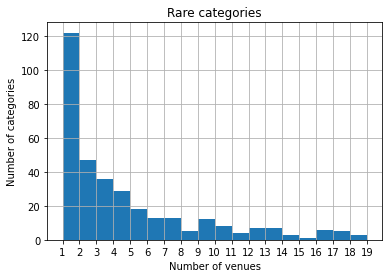

In [106]:
plt.hist(category_counts[category_counts < 20], bins=range(1,20)) # Plot histogram
plt.xticks(range(1,20,1))
plt.xlabel('Number of venues')
plt.ylabel('Number of categories')
plt.title('Rare categories')
plt.grid()
plt.show()

We see that a very large proportion of venue categories appear less than 5 times in the list. We can remove these from our model.

In [107]:
df_venues = df_venues[df_venues['Venue Category'].isin(category_counts[category_counts >= 5].index)]
df_venues.reset_index()
df_venues.shape

(2694, 7)

Now we check how many datapoints we have per postal code.

In [108]:
venue_counts = df_venues.groupby('Postal Code')['Venue'].count().sort_values(ascending=False)
print('Total number of rows is',venue_counts.count())
print('Number of rows with < 10 venues is', venue_counts.where(venue_counts < 10).count())

Total number of rows is 90
Number of rows with < 10 venues is 7


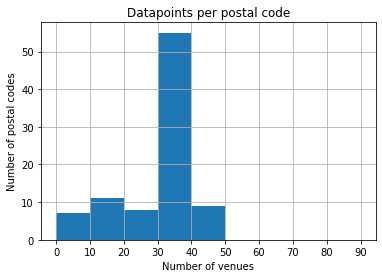

In [109]:
plt.hist(venue_counts, bins=range(0,100,10))
plt.xticks(range(0,100,10))
plt.xlabel('Number of venues')
plt.ylabel('Number of postal codes')
plt.title('Datapoints per postal code')
plt.grid()
plt.show()

This is a reasonable dataset for clustering. The majority of the postal codes have between 30 and 50 datapoints (venues) which shoud be sufficient for our purposes.

## K-means Clustering Model

Now the data is almost ready for clustering. The K-Means method will be employed for this exercise.

Before this though, we have to convert Venue Category using one-hot encoding and then group by postal code.

### Data Transformation

We need to one-hot encode the venue categories from this dataframe. We will use pandas.get_dummies to accomplish this.

In [157]:
df_dummies = pd.get_dummies(df_venues['Venue Category'], prefix='', prefix_sep='', sparse=False, drop_first=True)
print(df_dummies.shape)
print(df_dummies.columns)

(2694, 141)
Index(['American Restaurant', 'Art Gallery', 'Arts & Crafts Store',
       'Asian Restaurant', 'Athletics & Sports', 'Auto Dealership',
       'Automotive Shop', 'BBQ Joint', 'Bagel Shop', 'Bakery',
       ...
       'Tennis Court', 'Thai Restaurant', 'Thrift / Vintage Store', 'Trail',
       'University', 'Vegetarian / Vegan Restaurant', 'Veterinarian',
       'Vietnamese Restaurant', 'Women's Store', 'Yoga Studio'],
      dtype='object', length=141)


Lets add the postal codes to this data and create a new dataframe.

In [158]:
df_encoded = pd.merge(df_venues['Postal Code'], df_dummies, how='inner', left_index=True, right_index=True)
df_encoded.head()

,Postal Code,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,...,Tennis Court,Thai Restaurant,Thrift / Vintage Store,Trail,University,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant,Women's Store,Yoga Studio
0,M3A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M3A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M3A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M3A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M3A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we group by postal code and find the mean of all columns, to build a profile for each neighbourhood.

In [159]:
df_grouped = df_encoded.groupby('Postal Code').mean()
df_grouped

,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,...,Tennis Court,Thai Restaurant,Thrift / Vintage Store,Trail,University,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant,Women's Store,Yoga Studio
Postal Code,,,,,,,,,,,,,,,,,,,,,
M1B,0.000000,0.000000,0.032258,0.0,0.032258,0.0,0.096774,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
M1C,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.090909,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
M1E,0.000000,0.000000,0.000000,0.0,0.027778,0.0,0.000000,0.000000,0.000000,0.027778,...,0.000000,0.000000,0.055556,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
M1G,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
M1H,0.000000,0.000000,0.000000,0.0,0.027778,0.0,0.055556,0.000000,0.000000,0.027778,...,0.027778,0.000000,0.000000,0.0,0.0,0.027778,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M9N,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
M9P,0.027027,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.027027,0.000000,0.000000,...,0.000000,0.027027,0.000000,0.0,0.0,0.000000,0.027027,0.0,0.0,0.0
M9R,0.031250,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.031250,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


### Determining K-Value

We will use two methods - the Elbow method and the Silhouette method to study the results with different K-values.

In [160]:
sse_score = []
sil_score = []
k_range = range(2,10) # Range of values to check for k

for k in k_range:
    test_model = KMeans(n_clusters=k).fit(df_grouped)
    sse_score.append(test_model.inertia_)
    sil_score.append(silhouette_score(df_grouped, test_model.labels_))

print(sse_score)
print(sil_score)

[4.613547604775445, 4.3467959801027565, 4.105308951381133, 4.028074693701843, 3.837010165048124, 3.6952696990526275, 3.5073902004275705, 3.4500741572321374]
[0.051104557578554054, 0.0584421817934528, 0.07017540432712448, 0.04867823178897009, 0.0420716523542137, 0.04511797552213329, 0.05317358564807228, 0.03657681369708059]


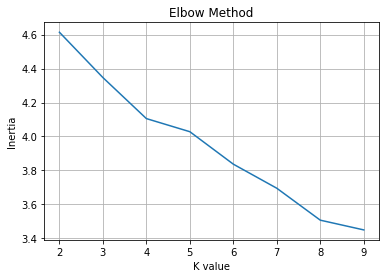

In [161]:
# Plot Elbow graph
plt.plot(k_range, sse_score)
plt.xlabel('K value')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid()
plt.show()

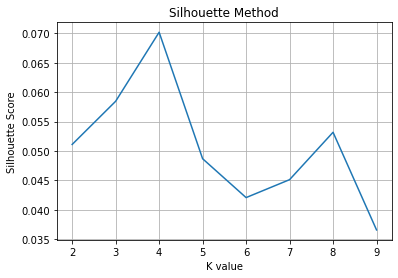

In [162]:
# Plot Silhouette Score Graph
plt.plot(k_range, sil_score)
plt.xlabel('K value')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.grid()
plt.show()

This model does not appear to give us good results. Both the inertia and the silhouette score show fairly linear relationships with the k-value, with no clear elbow point or peaks (considering the range of values is low for the silhouette scores).

We will use k=4 and proceed to map and explore the data.

## Interpreting and Visualizing Clusters

First, lets build the final model with the selected k-value of 4.

In [169]:
kmeans = KMeans(n_clusters=4).fit(df_grouped) # Create the model

# Create a new dataframe with cluster labels
df_clustered = df_grouped
df_clustered.insert(0, 'Cluster', kmeans.labels_)
df_clustered.head()

,Cluster,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,...,Tennis Court,Thai Restaurant,Thrift / Vintage Store,Trail,University,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant,Women's Store,Yoga Studio
Postal Code,,,,,,,,,,,,,,,,,,,,,
M1B,2,0.0,0.0,0.032258,0.0,0.032258,0.0,0.096774,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
M1C,2,0.0,0.0,0.000000,0.0,0.000000,0.0,0.090909,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
M1E,0,0.0,0.0,0.000000,0.0,0.027778,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.055556,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
M1G,2,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
M1H,1,0.0,0.0,0.000000,0.0,0.027778,0.0,0.055556,0.0,0.0,...,0.027778,0.0,0.000000,0.0,0.0,0.027778,0.0,0.0,0.0,0.0


Let's check the top venue categories in each cluster.

In [196]:
clusters = df_clustered.groupby('Cluster').mean()
clusters

,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,...,Tennis Court,Thai Restaurant,Thrift / Vintage Store,Trail,University,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant,Women's Store,Yoga Studio
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.007051,0.000000,0.006897,0.002778,0.002941,0.025857,0.000000,0.000000,0.009444,...,0.005733,0.000000,0.005556,0.005733,0.006549,0.000000,0.007179,0.000000,0.003333,0.000000
1,0.000000,0.002778,0.003584,0.000000,0.022134,0.009810,0.108311,0.000000,0.000000,0.015990,...,0.003086,0.006443,0.003367,0.010101,0.000000,0.003086,0.000000,0.000000,0.003175,0.000000
2,0.006426,0.003115,0.003063,0.003984,0.002447,0.003755,0.015827,0.002484,0.000659,0.014341,...,0.004618,0.003102,0.000000,0.004296,0.001590,0.000730,0.001602,0.003481,0.000795,0.000000
3,0.004875,0.005739,0.003237,0.006890,0.004555,0.001423,0.003771,0.004664,0.003183,0.021241,...,0.001558,0.004464,0.003257,0.000817,0.001838,0.003324,0.002493,0.003976,0.001508,0.005153


In [229]:
cluster_profiles = pd.DataFrame()

for i, row in clusters.iterrows():
    col = 'Cluster ' + str(i)
    col_data = []
    for j,v in row.sort_values(ascending=False).items():
        #print(v)
        col_data.append(str(j) + ' (' + str(round(v,3)) + ')')

    # col_data = row.sort_values(ascending=False).index
    cluster_profiles.insert(i, col, col_data)

cluster_profiles.head(10) # We can use this to display the top N features of each cluster

,Cluster 0,Cluster 1,Cluster 2,Cluster 3
0,Residential Building (Apartment / Condo) (0.194),Automotive Shop (0.108),Office (0.09),Coffee Shop (0.057)
1,Park (0.069),Gas Station (0.053),Park (0.047),Residential Building (Apartment / Condo) (0.048)
2,Office (0.065),Fast Food Restaurant (0.035),Church (0.045),Pharmacy (0.031)
3,School (0.031),Clothing Store (0.028),Building (0.038),Grocery Store (0.028)
4,Building (0.028),Bank (0.026),Convenience Store (0.028),Park (0.026)
5,Automotive Shop (0.026),Office (0.023),School (0.028),Pizza Place (0.024)
6,Pool (0.026),Building (0.023),Salon / Barbershop (0.022),Building (0.023)
7,Convenience Store (0.021),Hardware Store (0.022),Medical Center (0.018),Doctor's Office (0.022)
8,Medical Center (0.021),Athletics & Sports (0.022),High School (0.017),Bakery (0.021)
9,Church (0.02),Residential Building (Apartment / Condo) (0.021),Bank (0.017),Salon / Barbershop (0.021)


### Naming Clusters

Looking at the types and frequency of venues in each of the clusters, we can assign them a broad description.

 - Cluster 0: Residential Urban
 - Cluster 1: Mixed
 - Cluster 2: Commercial
 - Cluster 3: Residential

The frequency of residential buildings is a clear differentiator between clusters. Between Clusters 0 and 3, there appears to be a difference in the density.

In [282]:
# Assign these names to a list for use later
cluster_names = ['Residential Dense', 'Mixed', 'Commercial', 'Residential']

In [236]:
# Lets assign each cluster a color for visualization
cmap = cm.get_cmap(name='Set1')
color_list = []
for i,v in clusters.iterrows():
    color_list.append(colors.rgb2hex(cmap(i)))
color_list

['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']

In [261]:
# Create map centred on Toronto
map_centre = [43.715383, -79.405678]
toronto_map = folium.Map(location=map_centre, zoom_start=11)

# Create a dataframe for mapping
df_map = pd.merge(df_trim, df_clustered[['Cluster']], how='inner', left_index=True, right_index=True)
df_map.head()

,Borough,Neighbourhood,Latitude,Longitude,Cluster
Postal Code,,,,,
M3A,North York,Parkwoods,43.753259,-79.329656,0
M4A,North York,Victoria Village,43.725882,-79.315572,0
M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,3
M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1
M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242,3


In [284]:
df_map.to_csv('../data/toronto_clusters.csv') # Save to csv for reference

In [286]:
# Create map centred on Toronto
map_centre = [43.715383, -79.405678]
cluster_map = folium.Map(location=map_centre, zoom_start=11)

for postal_code, row in df_map.iterrows():
    c = row['Cluster']
    label = 'Cluster ' + str(c) + ' : ' + cluster_names[c]
    lat = row['Latitude']
    lng = row['Longitude']
    clr = color_list[c]
    #Add marker
    folium.CircleMarker(
        [lat, lng],
        popup = label,
        color = clr,
        fill = True,
        fill_color = clr,
        fill_opacity = 0.7,
        radius = 10,
    ).add_to(cluster_map)

cluster_map # Display map